In [2]:
# Machine Learning Library
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [5]:
train_data = pd.read_csv("/kaggle/input/emotions/train.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

In [6]:
train_data.head

<bound method NDFrame.head of                                                  Comment  Emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
15995  i just had a very brief time in the beanbag an...  sadness
15996  i am now turning and i feel pathetic that i am...  sadness
15997                     i feel strong and good overall      joy
15998  i feel like this was such a rude comment and i...    anger
15999  i know a lot but i feel so stupid because i ca...  sadness

[16000 rows x 2 columns]>

In [7]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [8]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [9]:
train_data.shape

(16000, 3)

In [13]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [15]:
train_data.duplicated().sum()

1

In [4]:
train_data.drop_duplicates(inplace=True)

In [11]:
train_data.duplicated().sum()

0

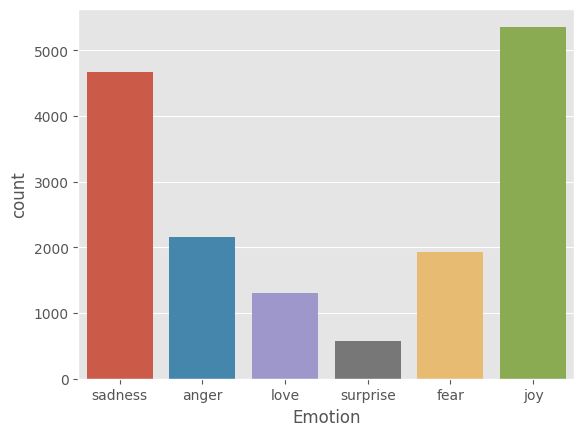

In [12]:
sns.countplot(x=train_data['Emotion'])
plt.show()

checking the frequency of each emotion in each comment length

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

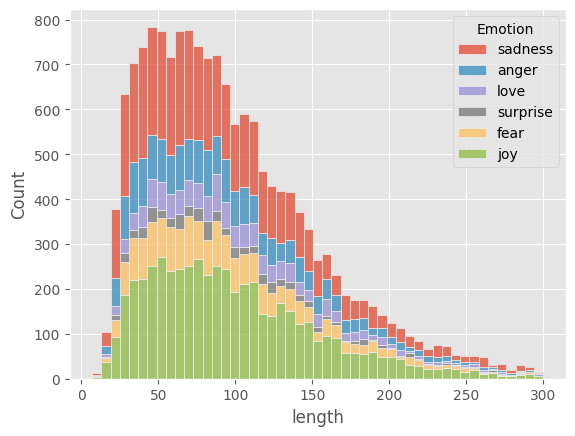

In [21]:
df2 = train_data.copy()
sns.histplot(data=df2, x='length',hue='Emotion',multiple = 'stack')
plt.show()

wordclouds for each emotion to find the most frequent words

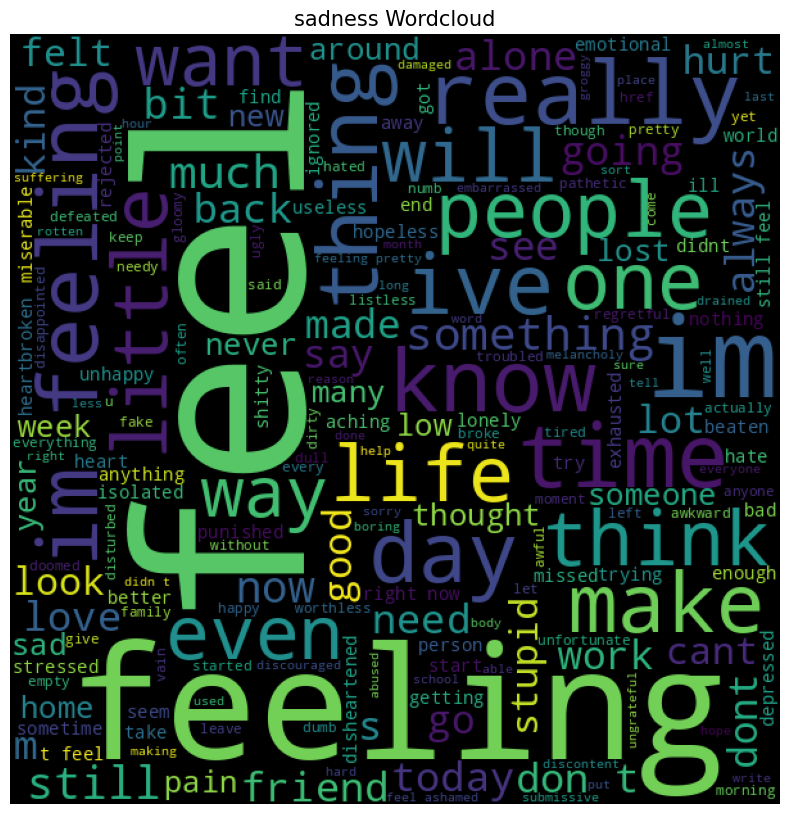

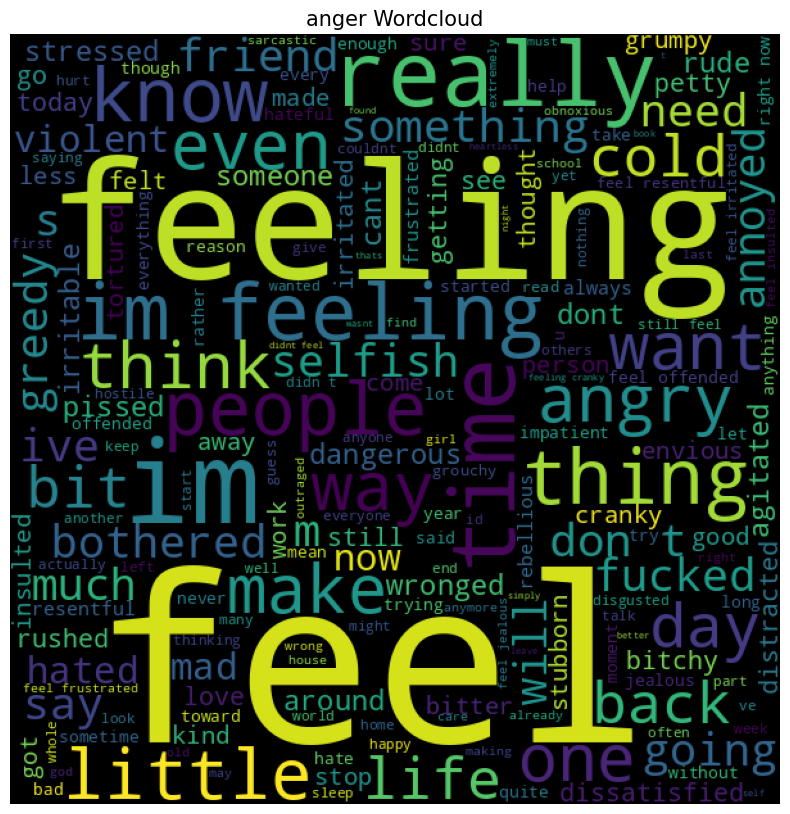

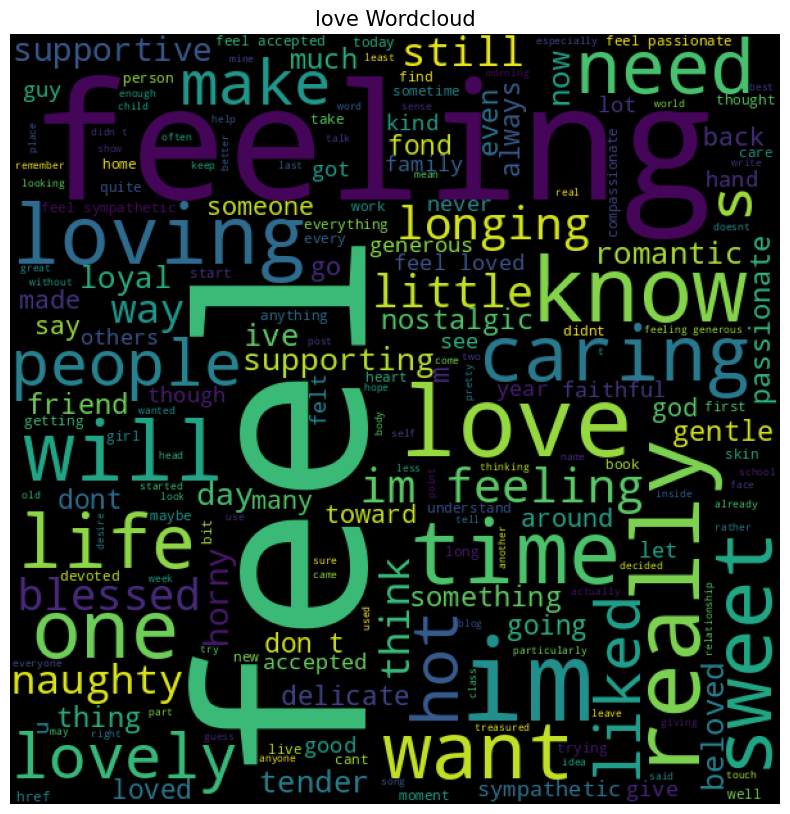

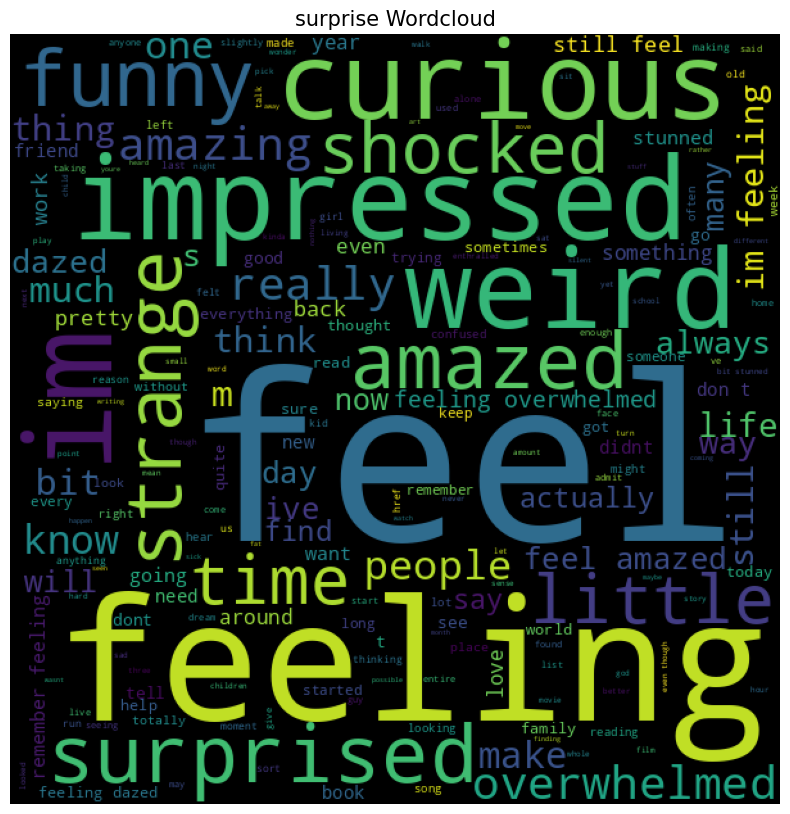

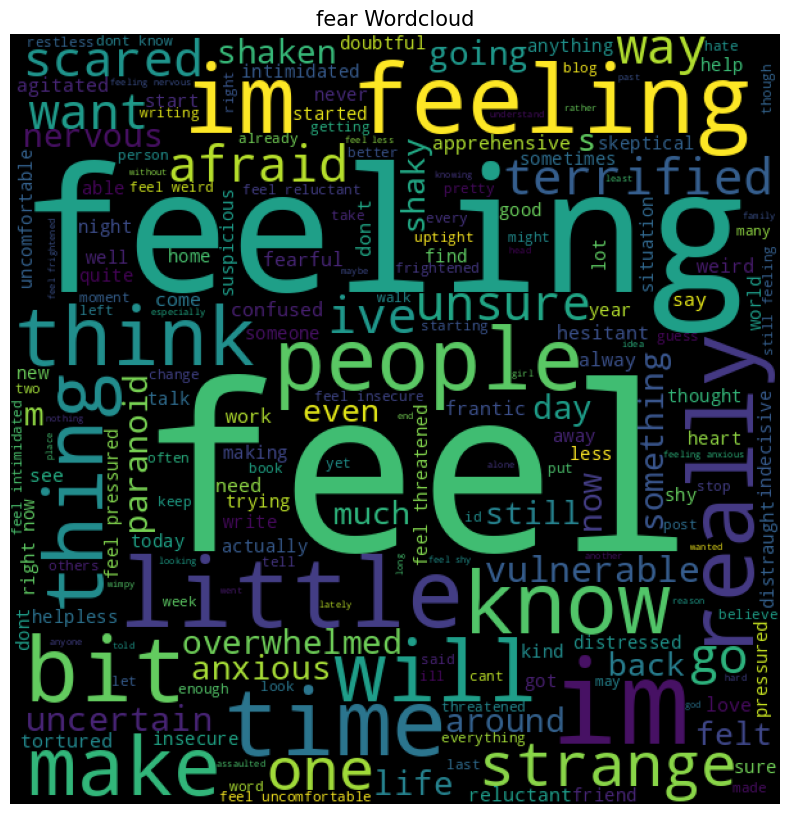

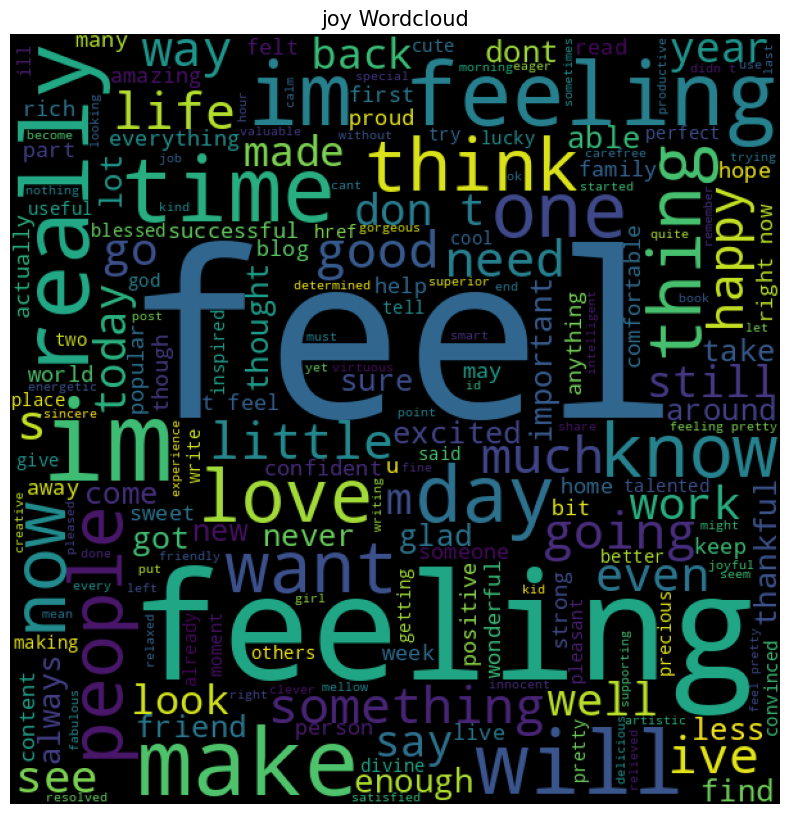

In [22]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(df + ' Wordcloud', size = 15)
    plt.imshow(wordcloud)
    plt.axis("off")
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

encode the emotions with numerical values (fit transform, so that we can do same encoding for test set)

In [7]:
train_data['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [11]:
df = train_data.copy()

In [12]:
from tqdm import tqdm  #for progress bar
tqdm.pandas()   #enables progress apply
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


removing stop words and stemming  (cleaning)

In [17]:
def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ",text)  #replace non alpha with space
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)

100%|██████████| 15999/15999 [00:06<00:00, 2429.17it/s]


In [18]:
df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


splitting for training and validation  (x_test is validation set)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size = 0.2, random_state=42)

**term frequence inverse document frequency** 
make words in to TFIDF features ensuring that both the training and test data are represented in the same feature space

In [21]:
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [22]:
X_train_tfidf.shape

(12799, 9243)

predicting with basic ML models

In [23]:
classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'Random Forest':RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

for name,clf in classifier.items():
    print(f"\n============{name}============")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"acuracy={accuracy_tfidf}")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf))


============MultinomialNB============
acuracy=0.6590625
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


============LogisticRegression============


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


acuracy=0.8240625
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.46      0.59       303
           4       0.88      0.92      0.90       950
           5       0.74      0.46      0.57       106

    accuracy                           0.82      3200
   macro avg       0.82      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200


============Random Forest============
acuracy=0.85125
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       439
           1       0.83      0.86      0.84       375
           2       0.84      0.89      0.86      1027
           3       0.83      0.61      0.71       303
           4       0.92      0.89      0.90       950
           5   

MultinomialNB: Uses default hyperparameters for alpha (Laplace smoothing), fit_prior, and class_prior.
LogisticRegression: Uses default values for regularization (C=1.0), solver ('lbfgs'), and other parameters.
RandomForestClassifier: Uses default settings for the number of estimators (n_estimators=100), maximum depth, and other hyperparameters.
SVC: Uses default values for the regularization parameter (C=1.0), kernel ('rbf'), and other parameters.

In [ ]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [36]:

def predict_emotion(input_text):
    cleaned_text = clean_data(input_text)
    input_vectorizer = tfidfvectorizer.transform([cleaned_text])
    
    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]    #decode the label encoded values
    label = np.max(lg.predict(input_vectorizer))
    
    return predicted_emotion, label

In [37]:
predict_emotion("i hate you")

('anger', 0)

saving the model , label encoder and vectorizer so that we can import and predict later given a comment

In [38]:
import pickle
pickle.dump(lg, open("logistic_regression.pkl","wb"))
pickle.dump(lb, open("label_encoder.pkl","wb"))
pickle.dump(tfidfvectorizer, open("tfidfvectorizer.pkl","wb"))

# Data Cleaning for LSTM

In [13]:
# Machine Learning Library
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
plt.style.use('ggplot')

In [26]:
train_data = pd.read_csv("/kaggle/input/emotions/train.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

In [27]:
train_data.drop_duplicates(inplace=True)

In [30]:
train_data["Emotion"].isnull().sum()

0

In [31]:
train_data.head

<bound method NDFrame.head of                                                  Comment  Emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
15995  i just had a very brief time in the beanbag an...  sadness
15996  i am now turning and i feel pathetic that i am...  sadness
15997                     i feel strong and good overall      joy
15998  i feel like this was such a rude comment and i...    anger
15999  i know a lot but i feel so stupid because i ca...  sadness

[15999 rows x 2 columns]>

In [32]:
emotion_mapping = {
    'sadness': 0,
    'anger': 1,
    'love': 2,
    'surprise': 3,
    'fear': 4,
    'joy': 5
}

train_data['Emotion'] = train_data['Emotion'].map(emotion_mapping)

In [41]:
train_data.head

<bound method NDFrame.head of                                                  Comment  Emotion
0                                i didnt feel humiliated        0
1      i can go from feeling so hopeless to so damned...        0
2       im grabbing a minute to post i feel greedy wrong        1
3      i am ever feeling nostalgic about the fireplac...        2
4                                   i am feeling grouchy        1
...                                                  ...      ...
15995  i just had a very brief time in the beanbag an...        0
15996  i am now turning and i feel pathetic that i am...        0
15997                     i feel strong and good overall        5
15998  i feel like this was such a rude comment and i...        1
15999  i know a lot but i feel so stupid because i ca...        0

[15999 rows x 2 columns]>

In [34]:
from tqdm import tqdm  #for progress bar
tqdm.pandas()   #enables progress apply
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# " corpus = [
#     "I love this product",
#     "It is not good",
#     "Amazing quality and great service"
# ]

# one_hot_word = [
#     [1, 6, 2, 5],
#     [3, 9, 7, 8],
#     [4, 2, 1, 5, 3, 9]

# max_len = 6
# padded_sequences = [
#     [0, 0, 1, 6, 2, 5],
#     [0, 0, 3, 9, 7, 8],
#     [4, 2, 1, 5, 3, 9]
# ]

# " 

In [40]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ",text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_sentences = [one_hot(input_text=sentence, n=vocab_size) for sentence in corpus]
    pad = pad_sequences(sequences=one_hot_sentences, maxlen=max_len, padding="pre")
    return pad

**we are getting numpy arrays 300 cols (each sentence has 300 values (stemmed words) between 0 to 11000)
and rows as same as the train_data set (for each record)**

In [42]:
x_train, x_test, y_train, y_test = train_test_split(train_data['Comment'], train_data['Emotion'], test_size = 0.2, random_state=42)

In [53]:
x_train_c = pd.DataFrame(x_train, columns=["Comment"])


In [54]:
print(x_train.head)

<bound method NDFrame.head of                                                  Comment
676    i refers of course though i cant help feeling ...
14180  i would feel awkward when someone tells his or...
7077   i feel like i probably would have liked this b...
13004  ive slowed down i take time to listen to my ch...
10264  i feel it is vital that a rlsh gimmick needs t...
...                                                  ...
13418  i love this because to me it should leave the ...
5390                             i feel is very delicate
860             i was starting to feel a little stressed
15796  i feel are acceptable in music and as such any...
7270   i feel that someone is being rude or has wrong...

[12799 rows x 1 columns]>


In [55]:
x_train_cleaned = text_cleaning(x_train_c, "Comment", vocab_size=11000, max_len=300)
y_train_cleaned = to_categorical(y_train)

In [57]:
x_train_cleaned.shape


(12799, 300)

In [ ]:
# train_data["Emotion"] = [0, 1, 2, 3, 4, 5, 0, 2]

# y_train = [
#  [1, 0, 0, 0, 0, 0],
#  [0, 1, 0, 0, 0, 0], 
#  [0, 0, 1, 0, 0, 0], 
#  [0, 0, 0, 0, 1, 0],  
#  [0, 0, 0, 0, 0, 1],
#  [0, 0, 1, 0, 0, 0]  ]
# emotions has values from 0 to 5 we are one hot encoding them

In [58]:
y_train_cleaned.shape

(12799, 6)

In [59]:
# Suppose your input sequence is [1, 23, 7...]:  (0-11000)    (300)

# The Embedding layer will convert this sequence into: (300,150)
# [
#   [0.23, -0.17, 0.45, ..., 0.31],  # Dense vector for word index 1   (dim 150)
#   [0.04, 0.21, -0.34, ..., -0.19], # Dense vector for word index 23
#   [0.55, -0.12, 0.07, ..., 0.12]   # Dense vector for word index 7
# ]


#if we have 1 sentence (1,300)  --->   (1,300,150)

In [60]:
#LSTM layer takes 300 time steps (feature length for each sentence ) each having 150 dim vector.
# (it goes through 300 steps each having forget gate,input gate,output gate)
# lstm has 128 neurons takes these inputs

In [62]:
model = Sequential()
model.add(Embedding(input_dim = 11000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train_cleaned, y_train_cleaned, epochs = 10, batch_size = 64, verbose = 1, callbacks=[callback])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 430ms/step - accuracy: 0.3729 - loss: 1.5656
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 432ms/step - accuracy: 0.7941 - loss: 0.6048
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 474ms/step - accuracy: 0.9169 - loss: 0.2317
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 490ms/step - accuracy: 0.9521 - loss: 0.1406
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 99s 494ms/step - accuracy: 0.9636 - loss: 0.1028
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 97s 486ms/step - accuracy: 0.9691 - loss: 0.0882
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 490ms/step - accuracy: 0.9751 - loss: 0.0724
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 514ms/step - accuracy: 0.9774 - loss: 0.0633
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 491ms/step - accuracy: 0.9804 - loss: 0.0548
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 101s 506ms/step - accuracy: 0.9840 - loss: 0.0460


save model

In [63]:
model.save("model_lstm_new.h5")

In [64]:
from keras.models import load_model
lstm_emo_classifier = load_model("/kaggle/working/model_lstm_new.h5")

**evaluating with the test set**

In [73]:
test_data = pd.read_csv("/kaggle/input/emotions/test.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

In [74]:
emotion_mapping = {
    'sadness': 0,
    'anger': 1,
    'love': 2,
    'surprise': 3,
    'fear': 4,
    'joy': 5
}

test_data['Emotion'] = test_data['Emotion'].map(emotion_mapping)

In [75]:
x_test= test_data['Comment']
y_test= test_data['Emotion']

In [76]:
x_test_c = pd.DataFrame(x_test, columns=["Comment"])

In [77]:
x_test_cleaned = text_cleaning(x_test_c, "Comment", vocab_size=11000, max_len=300)
y_test_cleaned = to_categorical(y_test)

In [78]:
print(x_test_cleaned.shape,y_test_cleaned.shape)

(2000, 300) (2000, 6)


In [79]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_cleaned, y_test_cleaned, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.8573 - loss: 0.5957
Test Loss: 0.5555042028427124
Test Accuracy: 0.8600000143051147


In [80]:
# Predict classes on the test set
y_pred_prob = model.predict(x_test_cleaned)
y_pred = np.argmax(y_pred_prob, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step


In [82]:
y_pred

array([0, 0, 0, ..., 5, 5, 4])

In [84]:
reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}


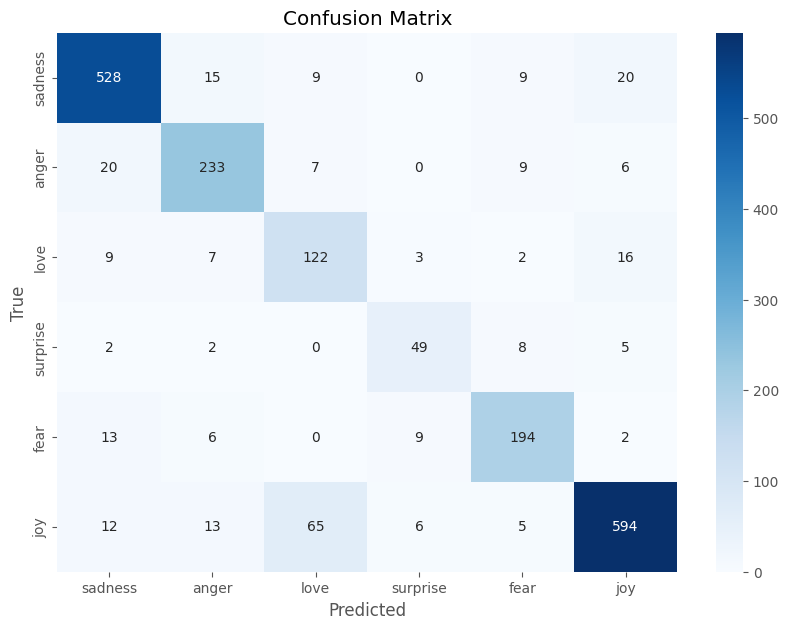

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=reverse_emotion_mapping.values(), yticklabels=reverse_emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# Below this to get a prediction from model

In [ ]:
from keras.models import load_model
lstm_emo_classifier = load_model("/kaggle/working/model_lstm_new.h5")

In [86]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    print(corpus)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [87]:
emotion_mapping = {
    'sadness': 0,
    'anger': 1,
    'love': 2,
    'surprise': 3,
    'fear': 4,
    'joy': 5
}

In [88]:
reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

In [93]:
sentence = predictive_system_dl("Battery is trashed essentially making the phone unusable.  Complete waste of money.")
prediction=lstm_emo_classifier.predict(sentence)
predicted_class_index = np.argmax(prediction, axis=1)[0]    #np.argmax get the index of max probabiity , then label encoder decodes the index
result = reverse_emotion_mapping[predicted_class_index]
prob = np.max(prediction)   #maximum probability of numpy array
print(f"{result} with probability of {prob}")

['batteri trash essenti make phone unus complet wast money']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
sadness with probability of 0.9787499904632568


just trying out more

In [94]:
sentence = predictive_system_dl("This is literally a brand new phone for a used phone price. I could not find a single scratch on this phone. I am so happy with this purchase. Saved a ton of money too.")
prediction=lstm_emo_classifier.predict(sentence)
predicted_class_index = np.argmax(prediction, axis=1)[0]   
result = reverse_emotion_mapping[predicted_class_index]
prob = np.max(prediction)  
print(f"{result} with probability of {prob}")

['liter brand new phone use phone price could find singl scratch phone happi purchas save ton money']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
joy with probability of 0.9999868869781494


In [96]:
sentence = predictive_system_dl("I use mine as a can opener. No, just kidding, really is a good value over getting locked into some high priced phone plan just to get a free phone which of course is not free at all. We bought 2 to replace our trusty and reliable 6s’s. We’ve had those since they first invented dirt. We got our money’s worth out of those for sure.<br />Download polycam and play! Too cool. Wife loves hers, I do too.")
prediction=lstm_emo_classifier.predict(sentence)
predicted_class_index = np.argmax(prediction, axis=1)[0]   
result = reverse_emotion_mapping[predicted_class_index]
prob = np.max(prediction)  
print(f"{result} with probability of {prob}")

['use mine open kid realli good valu get lock high price phone plan get free phone cours free bought replac trusti reliabl sinc first invent dirt got money worth sure br download polycam play cool wife love']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
joy with probability of 0.9999655485153198
